# CRS Arena - Data Analysis

This notebook presents an analysis of the data collected from the CRS Arena.

In [1]:
import pandas as pd
import seaborn as sns
from collections import defaultdict
import json
from statistics import mean, median, stdev
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import itertools
import numpy as np
from metrics import DistinctNgrams
from scipy.stats import spearmanr, pearsonr

## Conversations

This section presents an analysis of the conversations collected. It includes the distribution of conversations per CRS, statistics on the conversations (e.g., number of turns and number of words), and the analysis of user sentiments.

In [2]:
dk_dialogues = json.load(open("../data/crs_arena_dial_open.json"))

Closed crowdsourced environment

In [3]:
dk_dialogues_prolific = json.load(open("../data/crs_arena_dial_closed.json"))

In [4]:
print(f"Number of conversations collected in an open crowdsourced environment: {len(dk_dialogues)}")
print(f"Number of conversations collected in a closed crowdsourced environment: {len(dk_dialogues_prolific)}")

Number of conversations collected in an open crowdsourced environment: 254
Number of conversations collected in a closed crowdsourced environment: 220


#### Conversation distribution

In [5]:
num_conv_per_crs_open = defaultdict(int)
num_conv_per_crs_closed = defaultdict(int)

for conv in dk_dialogues:
    num_conv_per_crs_open[conv["agent"]["id"]] += 1

for conv in dk_dialogues_prolific:
    num_conv_per_crs_closed[conv["agent"]["id"]] += 1

conversations_distribution = pd.DataFrame({
    "Open crowdsourcing": num_conv_per_crs_open,
    "Closed crowdsourcing": num_conv_per_crs_closed
}).fillna(0)

In [6]:
conversations_distribution

,Open crowdsourcing,Closed crowdsourcing
barcor_redial,23,24
barcor_opendialkg,29,26
kbrd_opendialkg,38,21
kbrd_redial,35,27
chatgpt_redial,29,24
crbcrs_redial,37,26
unicrs_opendialkg,21,21
unicrs_redial,22,27
chatgpt_opendialkg,20,24


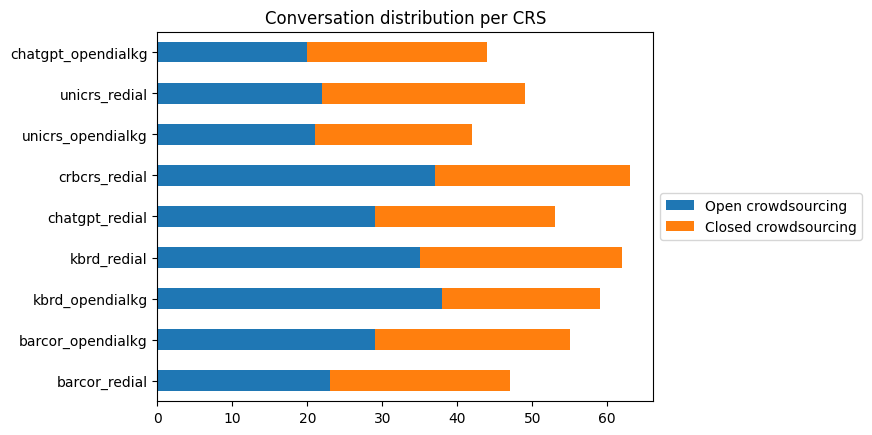

In [7]:
conversations_distribution.plot(kind="barh", stacked=True, title="Conversation distribution per CRS").legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Sentiment analysis

In [8]:
sentiment_data_open = defaultdict(lambda: defaultdict(int))
sentiment_data_closed = defaultdict(lambda: defaultdict(int))

for conv in dk_dialogues:
    sentiment_data_open[conv["agent"]["id"]][conv["metadata"]["sentiment"]] += 1

for conv in dk_dialogues_prolific:
    sentiment_data_closed[conv["agent"]["id"]][conv["metadata"]["sentiment"]] += 1

sentiment_distribution = pd.DataFrame({
    ("Open crowdsourcing", "Frustrated"): {crs: sentiment_data_open[crs].get("frustrated", 0) for crs in num_conv_per_crs_open.keys()},
    ("Open crowdsourcing" , "Satisfied"): {crs: sentiment_data_open[crs].get("satisfied", 0) for crs in num_conv_per_crs_open.keys()},
    ("Closed crowdsourcing", "Frustrated"): {crs: sentiment_data_closed[crs].get("frustrated", 0) for crs in num_conv_per_crs_closed.keys()},
    ("Closed crowdsourcing", "Satisfied"): {crs: sentiment_data_closed[crs].get("satisfied", 0) for crs in num_conv_per_crs_closed.keys()},
    ("Combined", "Frustrated"): {crs: sentiment_data_open[crs].get("frustrated", 0) + sentiment_data_closed[crs].get("frustrated", 0) for crs in num_conv_per_crs_open.keys()},
    ("Combined", "Satisfied"): {crs: sentiment_data_open[crs].get("satisfied", 0) + sentiment_data_closed[crs].get("satisfied", 0) for crs in num_conv_per_crs_open.keys()},
}).fillna(0)

In [9]:
sentiment_distribution

Open crowdsourcing           Closed crowdsourcing  \
                           Frustrated Satisfied           Frustrated   
barcor_redial                      16         7                   17   
barcor_opendialkg                  24         5                   23   
kbrd_opendialkg                    37         1                   21   
kbrd_redial                        32         3                   25   
chatgpt_redial                     12        17                   17   
crbcrs_redial                      35         2                   23   
unicrs_opendialkg                  19         2                   21   
unicrs_redial                      18         4                   26   
chatgpt_opendialkg                 10        10                   11   

                               Combined            
                   Satisfied Frustrated Satisfied  
barcor_redial              7         33        14  
barcor_opendialkg          3         47         8  
kbrd_opendialkg            0         58         1  
kbrd_redial                2         57         5  
chatgpt_redial             7         29        24  
crbcrs_redial              3         58         5  
unicrs_opendialkg          0         40         2  
unicrs_redial              1         44         5  
chatgpt_opendialkg        13         21        23

In [10]:
# Add columns with % satisfied
sentiment_distribution[("Open crowdsourcing", "% Satisfied")] = sentiment_distribution.apply(lambda x: round(x[("Open crowdsourcing", "Satisfied")] / (x[("Open crowdsourcing", "Satisfied")] + x[("Open crowdsourcing", "Frustrated")]),3), axis=1)
sentiment_distribution[("Closed crowdsourcing", "% Satisfied")] = sentiment_distribution.apply(lambda x: round(x[("Closed crowdsourcing", "Satisfied")] / (x[("Closed crowdsourcing", "Satisfied")] + x[("Closed crowdsourcing", "Frustrated")]),3), axis=1)
sentiment_distribution[("Combined", "% Satisfied")] = sentiment_distribution.apply(lambda x: round(x[("Combined", "Satisfied")] / (x[("Combined", "Satisfied")] + x[("Combined", "Frustrated")]),3), axis=1)

In [11]:
sentiment_distribution.sort_index()

Open crowdsourcing           Closed crowdsourcing  \
                           Frustrated Satisfied           Frustrated   
barcor_opendialkg                  24         5                   23   
barcor_redial                      16         7                   17   
chatgpt_opendialkg                 10        10                   11   
chatgpt_redial                     12        17                   17   
crbcrs_redial                      35         2                   23   
kbrd_opendialkg                    37         1                   21   
kbrd_redial                        32         3                   25   
unicrs_opendialkg                  19         2                   21   
unicrs_redial                      18         4                   26   

                               Combined           Open crowdsourcing  \
                   Satisfied Frustrated Satisfied        % Satisfied   
barcor_opendialkg          3         47         8              0.172   
barcor_redial              7         33        14              0.304   
chatgpt_opendialkg        13         21        23              0.500   
chatgpt_redial             7         29        24              0.586   
crbcrs_redial              3         58         5              0.054   
kbrd_opendialkg            0         58         1              0.026   
kbrd_redial                2         57         5              0.086   
unicrs_opendialkg          0         40         2              0.095   
unicrs_redial              1         44         5              0.182   

                   Closed crowdsourcing    Combined  
                            % Satisfied % Satisfied  
barcor_opendialkg                 0.115       0.145  
barcor_redial                     0.292       0.298  
chatgpt_opendialkg                0.542       0.523  
chatgpt_redial                    0.292       0.453  
crbcrs_redial                     0.115       0.079  
kbrd_opendialkg                   0.000       0.017  
kbrd_redial                       0.074       0.081  
unicrs_opendialkg                 0.000       0.048  
unicrs_redial                     0.037       0.102

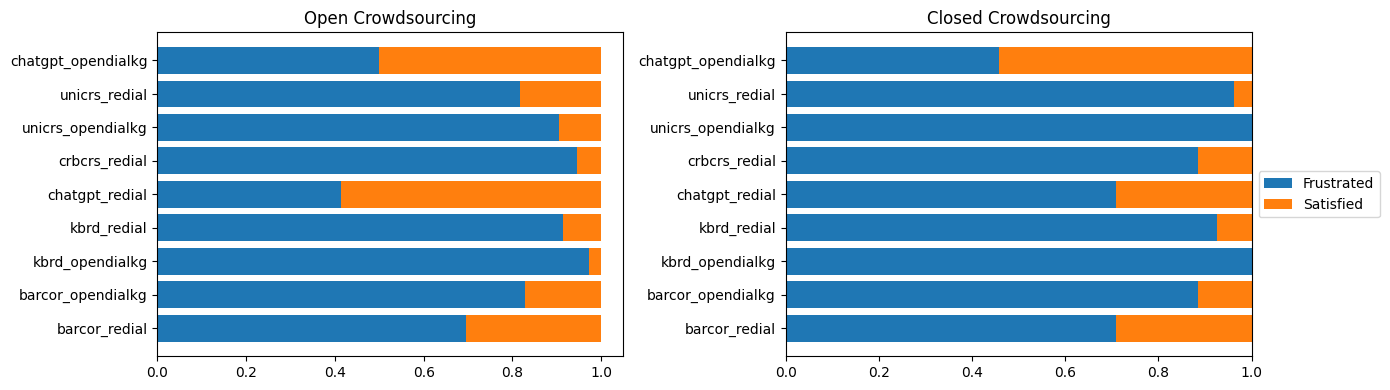

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

open_crowdsourcing_frustrated = sentiment_distribution[("Open crowdsourcing", "Frustrated")].values
open_crowdsourcing_satisfied = sentiment_distribution[("Open crowdsourcing", "Satisfied")].values
open_crowdsourcing_total = open_crowdsourcing_frustrated + open_crowdsourcing_satisfied
open_crowdsourcing_frustrated_percentage = open_crowdsourcing_frustrated / open_crowdsourcing_total
open_crowdsourcing_satisfied_percentage = open_crowdsourcing_satisfied / open_crowdsourcing_total

axs[0].barh(sentiment_distribution.index, open_crowdsourcing_frustrated_percentage, label="Frustrated")
axs[0].barh(sentiment_distribution.index, open_crowdsourcing_satisfied_percentage, left=open_crowdsourcing_frustrated_percentage, label="Satisfied")
axs[0].set_title("Open Crowdsourcing")

closed_crowdsourcing_frustrated = sentiment_distribution[("Closed crowdsourcing", "Frustrated")].values
closed_crowdsourcing_satisfied = sentiment_distribution[("Closed crowdsourcing", "Satisfied")].values
closed_crowdsourcing_total = closed_crowdsourcing_frustrated + closed_crowdsourcing_satisfied
closed_crowdsourcing_frustrated_percentage = closed_crowdsourcing_frustrated / closed_crowdsourcing_total
closed_crowdsourcing_satisfied_percentage = closed_crowdsourcing_satisfied / closed_crowdsourcing_total

axs[1].barh(sentiment_distribution.index, closed_crowdsourcing_frustrated_percentage, label="Frustrated")
axs[1].barh(sentiment_distribution.index, closed_crowdsourcing_satisfied_percentage, left=closed_crowdsourcing_frustrated_percentage, label="Satisfied")
axs[1].set_title("Closed Crowdsourcing")
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

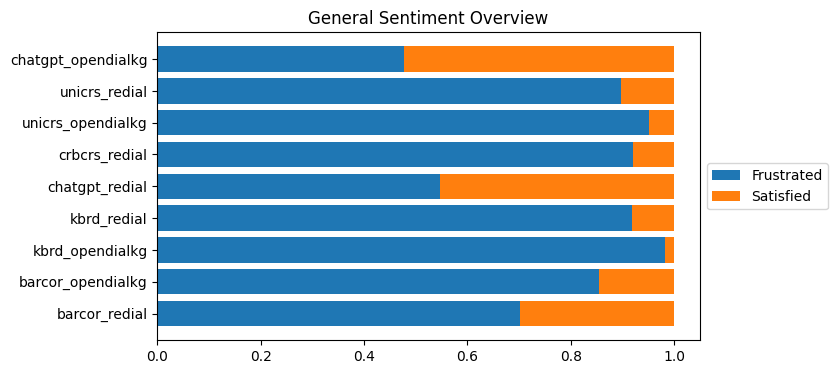

In [13]:
general_frustrated = sentiment_distribution[("Open crowdsourcing", "Frustrated")].values + sentiment_distribution[("Closed crowdsourcing", "Frustrated")].values
general_satisfied = sentiment_distribution[("Open crowdsourcing", "Satisfied")].values + sentiment_distribution[("Closed crowdsourcing", "Satisfied")].values
general_total = general_frustrated + general_satisfied
general_frustrated_percentage = general_frustrated / general_total
general_satisfied_percentage = general_satisfied / general_total

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

axs.barh(sentiment_distribution.index, general_frustrated_percentage, label="Frustrated")
axs.barh(sentiment_distribution.index, general_satisfied_percentage, left=general_frustrated_percentage, label="Satisfied")
axs.set_title("General Sentiment Overview")
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Conversation statistics

In [14]:
conversation_lengths_open = defaultdict(list)
conversation_lengths_closed = defaultdict(list)

for conv in dk_dialogues:
    conversation_lengths_open[conv["agent"]["id"]].append(len(conv["conversation"]))

for conv in dk_dialogues_prolific:
    conversation_lengths_closed[conv["agent"]["id"]].append(len(conv["conversation"]))


In [15]:
conversations_stats_open = {crs: {"mean": round(mean(lengths),3), "median": median(lengths), "stdev": round(stdev(lengths),3)} for crs, lengths in conversation_lengths_open.items()}
conversations_stats_closed = {crs: {"mean": round(mean(lengths),3), "median": median(lengths), "stdev": round(stdev(lengths),3)} for crs, lengths in conversation_lengths_closed.items()}

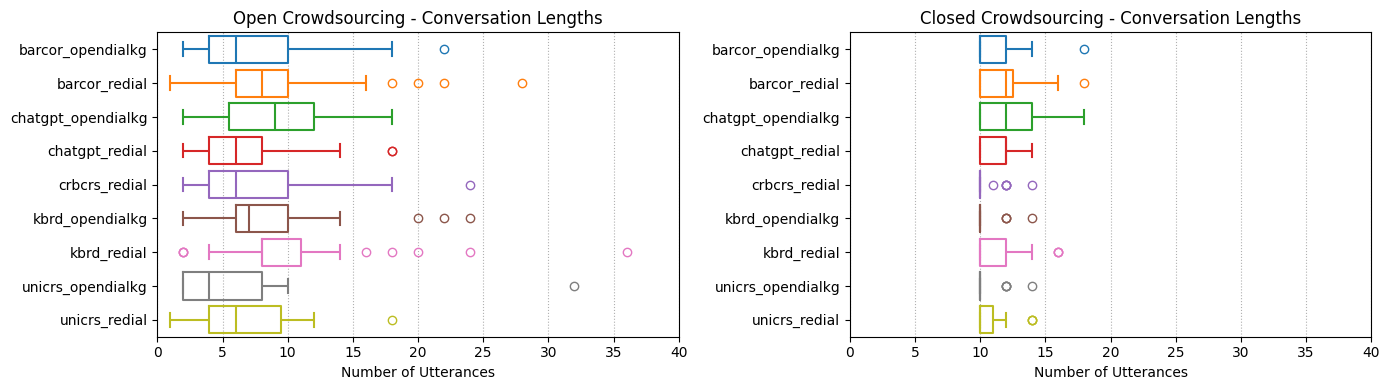

In [16]:
conversation_lengths_open = dict(sorted(conversation_lengths_open.items()))
conversation_lengths_closed = dict(sorted(conversation_lengths_closed.items()))

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(conversation_lengths_open, ax=axs[0],orient="h", fill=False)
axs[0].set_title("Open Crowdsourcing - Conversation Lengths")
axs[0].set_xlabel("Number of Utterances")
axs[0].set_xlim(0, 40)
axs[0].grid(True, axis="x", linestyle=":")

sns.boxplot(conversation_lengths_closed, ax=axs[1],orient="h", fill=False)
axs[1].set_title("Closed Crowdsourcing - Conversation Lengths")
axs[1].set_xlabel("Number of Utterances")
axs[1].set_xlim(0, 40)
axs[1].grid(True, axis="x", linestyle=":")

fig.tight_layout()
plt.show()


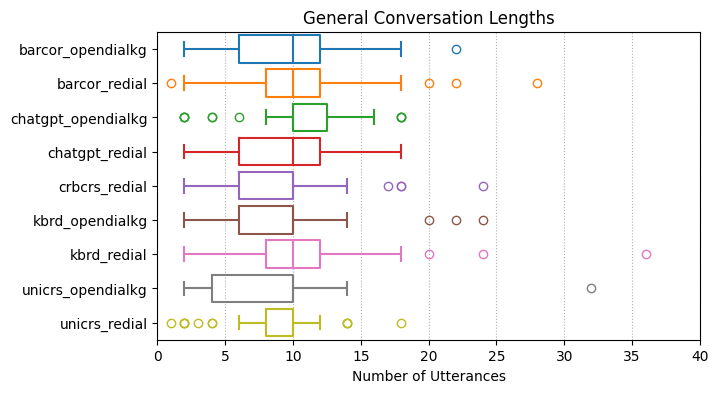

In [17]:
conversation_lengths = {crs: lengths + conversation_lengths_closed[crs] for crs, lengths in conversation_lengths_open.items()}
conversation_lengths = dict(sorted(conversation_lengths.items()))

fig, axs = plt.subplots(1, 1, figsize=(7, 4))
sns.boxplot(conversation_lengths, orient="h", fill=False)
plt.title("General Conversation Lengths")
plt.xlabel("Number of Utterances")
plt.xlim(0, 40)
plt.grid(True, axis="x", linestyle=":")
plt.show()

In [18]:
utterance_lengths_open = defaultdict(list)
utterance_lengths_closed = defaultdict(list)

for conv in dk_dialogues:
    for utterance in conv["conversation"]:
        utterance_lengths_open[conv["agent"]["id"]].append(len(utterance["utterance"].split()))

for conv in dk_dialogues_prolific:
    for utterance in conv["conversation"]:
        utterance_lengths_closed[conv["agent"]["id"]].append(len(utterance["utterance"].split()))

In [19]:
utterance_stats_open = {crs: {"mean": round(mean(lengths),3), "median": median(lengths), "stdev": round(stdev(lengths),3)} for crs, lengths in utterance_lengths_open.items()}
utterance_stats_closed = {crs: {"mean": round(mean(lengths),3), "median": median(lengths), "stdev": round(stdev(lengths),3)} for crs, lengths in utterance_lengths_closed.items()}

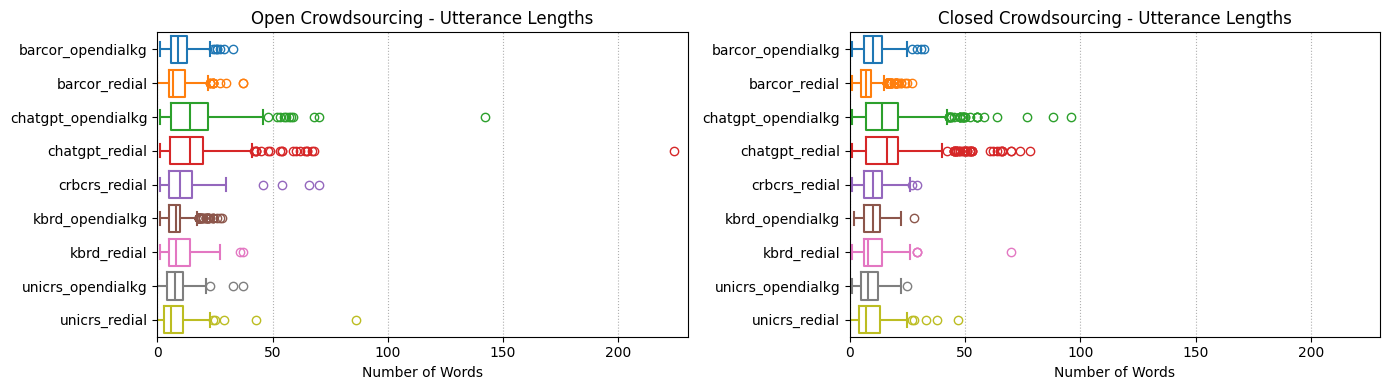

In [20]:
utterance_lengths_open = dict(sorted(utterance_lengths_open.items()))
utterance_lengths_closed = dict(sorted(utterance_lengths_closed.items()))

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(utterance_lengths_open, ax=axs[0],orient="h", fill=False)
axs[0].set_title("Open Crowdsourcing - Utterance Lengths")
axs[0].set_xlabel("Number of Words")
axs[0].set_xlim(0, 230)
axs[0].grid(True, axis="x", linestyle=":")

sns.boxplot(utterance_lengths_closed, ax=axs[1],orient="h", fill=False)
axs[1].set_title("Closed Crowdsourcing - Utterance Lengths")
axs[1].set_xlabel("Number of Words")
axs[1].set_xlim(0, 230)
axs[1].grid(True, axis="x", linestyle=":")

fig.tight_layout()
plt.show()


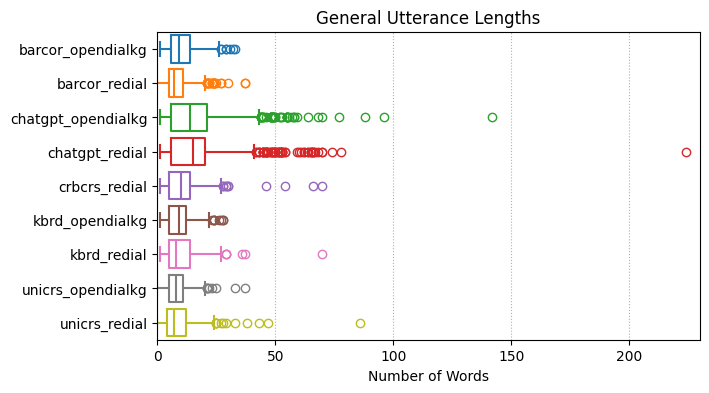

In [21]:
utterance_lengths = {crs: lengths + utterance_lengths_closed[crs] for crs, lengths in utterance_lengths_open.items()}
utterance_lengths = dict(sorted(utterance_lengths.items()))

fig, axs = plt.subplots(1, 1, figsize=(7, 4))
sns.boxplot(utterance_lengths, orient="h", fill=False)
plt.title("General Utterance Lengths")
plt.xlabel("Number of Words")
plt.xlim(0, 230)
plt.grid(True, axis="x", linestyle=":")
plt.show()

Summary

In [22]:
conversation_stats = {
    ("Open crowdsourcing", "Avg. # Utterances"): {crs: f"{stats['mean']} +/- {stats['stdev']}" for crs, stats in conversations_stats_open.items()},
    ("Open crowdsourcing", "Median # Utterances"): {crs: stats["median"] for crs, stats in conversations_stats_open.items()},
    ("Open crowdsourcing", "Avg. # Words"): {crs: f"{stats['mean']} +/- {stats['stdev']}" for crs, stats in utterance_stats_open.items()},
    ("Open crowdsourcing", "Median # Words"): {crs: stats["median"] for crs, stats in utterance_stats_open.items()},
    ("Closed crowdsourcing", "Avg. # Utterances"): {crs: f"{stats['mean']} +/- {stats['stdev']}" for crs, stats in conversations_stats_closed.items()},
    ("Closed crowdsourcing", "Median # Utterances"): {crs: stats["median"] for crs, stats in conversations_stats_closed.items()},
    ("Closed crowdsourcing", "Avg. # Words"): {crs: f"{stats['mean']} +/- {stats['stdev']}" for crs, stats in utterance_stats_closed.items()},
    ("Closed crowdsourcing", "Median # Words"): {crs: stats["median"] for crs, stats in utterance_stats_closed.items()}
}

conversation_stats_df = pd.DataFrame(conversation_stats).fillna(0)
conversation_stats_df

Open crowdsourcing                                         \
                    Avg. # Utterances Median # Utterances       Avg. # Words   
barcor_redial         9.609 +/- 6.733                 8.0    9.285 +/- 6.483   
barcor_opendialkg     8.103 +/- 5.017                 6.0   10.196 +/- 5.824   
kbrd_opendialkg       8.184 +/- 5.382                 7.0    8.932 +/- 5.937   
kbrd_redial          10.229 +/- 6.594                 8.0    9.592 +/- 6.426   
chatgpt_redial        6.586 +/- 4.289                 6.0  17.901 +/- 21.555   
crbcrs_redial         7.784 +/- 5.365                 6.0   10.948 +/- 8.445   
unicrs_opendialkg     6.095 +/- 6.678                 4.0    8.617 +/- 5.781   
unicrs_redial         6.818 +/- 3.996                 6.0      8.4 +/- 9.301   
chatgpt_opendialkg      9.2 +/- 4.959                 9.0  17.114 +/- 17.228   

                                  Closed crowdsourcing                      \
                   Median # Words    Avg. # Utterances Median # Utterances   
barcor_redial                 7.0      11.917 +/- 2.32                12.0   
barcor_opendialkg             9.0     11.077 +/- 1.896                10.0   
kbrd_opendialkg               8.0     10.476 +/- 1.078                10.0   
kbrd_redial                   8.0     11.333 +/- 2.075                10.0   
chatgpt_redial               14.0      11.75 +/- 1.482                12.0   
crbcrs_redial                10.0        10.5 +/- 1.03                10.0   
unicrs_opendialkg             7.5     10.571 +/- 1.121                10.0   
unicrs_redial                 6.0     10.741 +/- 1.375                10.0   
chatgpt_opendialkg           14.0     11.917 +/- 2.165                12.0   

                                                      
                         Avg. # Words Median # Words  
barcor_redial         7.986 +/- 5.212            7.0  
barcor_opendialkg    10.622 +/- 5.596           10.0  
kbrd_opendialkg        10.5 +/- 5.462           10.0  
kbrd_redial          10.137 +/- 7.078            8.0  
chatgpt_redial      19.053 +/- 16.691           16.0  
crbcrs_redial        10.139 +/- 5.905           10.0  
unicrs_opendialkg      8.59 +/- 4.819            8.0  
unicrs_redial          8.941 +/- 6.61            7.0  
chatgpt_opendialkg  17.643 +/- 15.854           14.0

## Battles

This section analyses the battles outcomes and produce a ranking of the CRSs based on Elo ratings.

In [23]:
votes_open_path = "../data/votes_open.csv"
votes_open_df = pd.read_csv(votes_open_path)

In [24]:
votes_closed_path = "../data/votes_closed.csv"
votes_closed_df = pd.read_csv(votes_closed_path)


Filter battles data to keep only the battles with valid conversations

In [25]:
valid_user_ids_open = set([dialogue["user"]["id"] for dialogue in dk_dialogues])
votes_open_df = votes_open_df[votes_open_df["user_id"].isin(valid_user_ids_open)]
votes_open_df

,session_id,user_id,crs1,crs2,vote,feedback
0,2024-09-08 23:01:08,e7eb4480-6951-4582-91ad-1d19ead970bb,kbrd_redial,kbrd_opendialkg,tie,NaN
1,2024-09-09 12:39:13,049a839e-89e5-4e0b-92e7-f72eb5052ca5,kbrd_redial,kbrd_opendialkg,kbrd_redial,NaN
2,2024-09-09 12:44:14,8460fdbb-3dee-4b19-aa3e-057b40b4b9a6,kbrd_redial,kbrd_opendialkg,kbrd_redial,"Based on the limited prompts I tried, I feel l..."
3,2024-09-09 19:07:53,27a7298f-4ca2-441a-83dc-011f5d1ed5ea,kbrd_redial,kbrd_opendialkg,kbrd_redial,NaN
4,2024-09-09 19:15:31,2e6d6a22-b6ab-438a-a183-91761d804b90,unicrs_redial,unicrs_opendialkg,unicrs_opendialkg,NaN
...,...,...,...,...,...,...
76,2024-09-13 10:53:33,94bd941f-595e-4345-ab42-bec55cfd6b4b,kbrd_redial,kbrd_opendialkg,kbrd_opendialkg,The conversation did not happen
77,2024-09-13 10:57:43,57ac2c8f-75fa-49ad-be36-574004b0c47a,unicrs_redial,unicrs_opendialkg,unicrs_opendialkg,NaN
78,2024-09-13 12:15:34,56759a2a-e597-41ec-85d5-e15bf9899ebf,kbrd_redial,kbrd_opendialkg,kbrd_redial,NaN
79,2024-09-13 12:45:57,f4e52cb8-a5e7-42be-8294-b61cdfcdf83d,kbrd_opendialkg,kbrd_redial,kbrd_redial,Neither of them answered the question I wanted...


### Number of battles for each CRS

In [26]:
battle_counts_open = votes_open_df.groupby(["crs1", "crs2"]).size().unstack().fillna(0)
battle_counts_closed = votes_closed_df.groupby(["crs1", "crs2"]).size().unstack().fillna(0)
print(f"Total number of battles in open crowdsourced environment: {battle_counts_open.sum().sum()}")
print(f"Total number of battles in closed crowdsourced environment: {battle_counts_closed.sum().sum()}")

Total number of battles in open crowdsourced environment: 81.0
Total number of battles in closed crowdsourced environment: 104.0


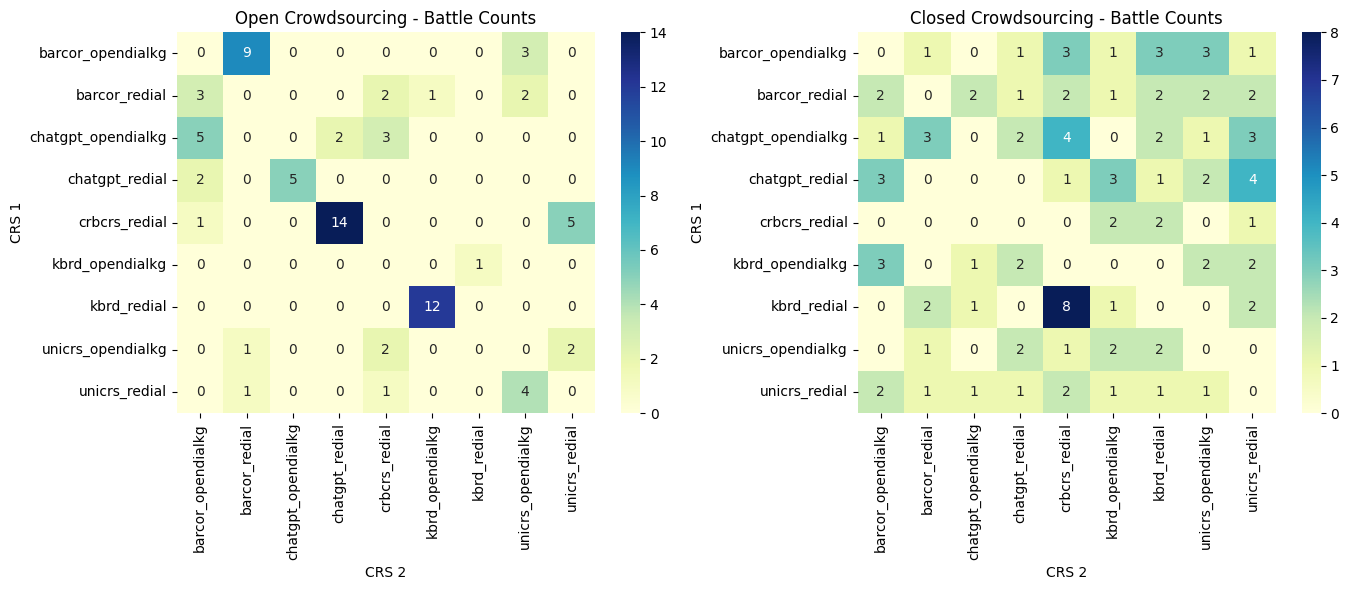

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(battle_counts_open, annot=True, fmt="g", cmap="YlGnBu", ax=axs[0])
axs[0].set_title("Open Crowdsourcing - Battle Counts")
axs[0].set_xlabel("CRS 2")
axs[0].set_ylabel("CRS 1")

sns.heatmap(battle_counts_closed, annot=True, fmt="g", cmap="YlGnBu", ax=axs[1])
axs[1].set_title("Closed Crowdsourcing - Battle Counts")
axs[1].set_xlabel("CRS 2")
axs[1].set_ylabel("CRS 1")

fig.tight_layout()
plt.show()

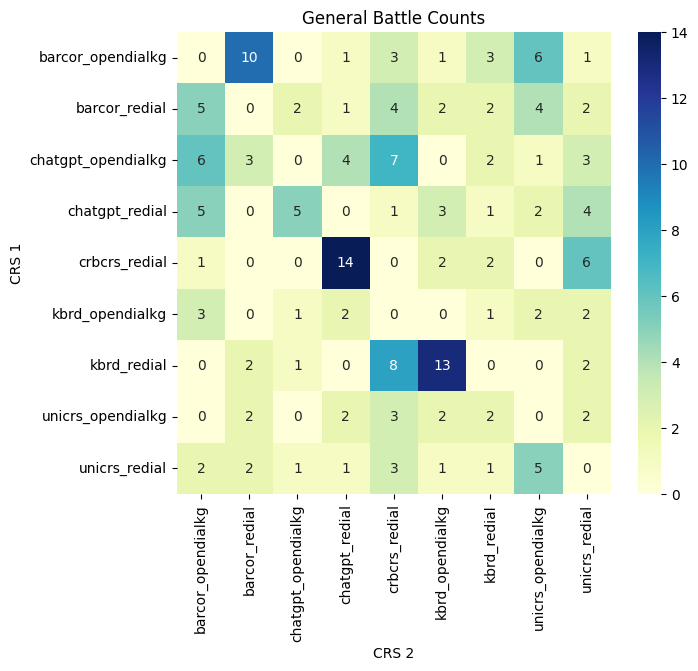

In [28]:
battle_counts = battle_counts_open + battle_counts_closed

fig, axs = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(battle_counts, annot=True, fmt="g", cmap="YlGnBu")
plt.title("General Battle Counts")
plt.xlabel("CRS 2")
plt.ylabel("CRS 1")
plt.show()

In [29]:
battle_counts

crs2,barcor_opendialkg,barcor_redial,chatgpt_opendialkg,chatgpt_redial,crbcrs_redial,kbrd_opendialkg,kbrd_redial,unicrs_opendialkg,unicrs_redial
crs1,,,,,,,,,
barcor_opendialkg,0.0,10.0,0.0,1.0,3.0,1.0,3.0,6.0,1.0
barcor_redial,5.0,0.0,2.0,1.0,4.0,2.0,2.0,4.0,2.0
chatgpt_opendialkg,6.0,3.0,0.0,4.0,7.0,0.0,2.0,1.0,3.0
chatgpt_redial,5.0,0.0,5.0,0.0,1.0,3.0,1.0,2.0,4.0
crbcrs_redial,1.0,0.0,0.0,14.0,0.0,2.0,2.0,0.0,6.0
kbrd_opendialkg,3.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,2.0
kbrd_redial,0.0,2.0,1.0,0.0,8.0,13.0,0.0,0.0,2.0
unicrs_opendialkg,0.0,2.0,0.0,2.0,3.0,2.0,2.0,0.0,2.0
unicrs_redial,2.0,2.0,1.0,1.0,3.0,1.0,1.0,5.0,0.0


### Proportion of ties

In [30]:
proportion_ties_open = votes_open_df[votes_open_df["vote"] == "tie"].shape[0] / votes_open_df.shape[0]
proportion_ties_closed = votes_closed_df[votes_closed_df["vote"] == "tie"].shape[0] / votes_closed_df.shape[0]

proportion_ties = (votes_open_df[votes_open_df["vote"] == "tie"].shape[0] + votes_closed_df[votes_closed_df["vote"] == "tie"].shape[0]) / (votes_open_df.shape[0] + votes_closed_df.shape[0])

print(f"Proportion of ties in open crowdsourced environment: {round(proportion_ties_open,3)}")
print(f"Proportion of ties in closed crowdsourced environment: {round(proportion_ties_closed, 3)}")
print(f"Proportion of ties in general: {round(proportion_ties,3)}")

Proportion of ties in open crowdsourced environment: 0.272
Proportion of ties in closed crowdsourced environment: 0.481
Proportion of ties in general: 0.389


### Elo ratings for each CRS

Note: Implementation is taken from FastChat (see [here](https://github.com/lm-sys/FastChat/blob/ef16c16cf148fef9eb11fdd2b28e63e61c2432d2/fastchat/serve/monitor/elo_analysis.py#L36))

In [31]:
def compute_elo_ratings(
    battle_outcomes: pd.DataFrame,
    k: int = 32,
    base: int = 10,
    scale: int = 400,
    initial_rating: int = 1000,
) -> pd.DataFrame:
    """Computes Elo ratings of competitors given battle outcomes.

    Args:
        battle_outcomes: Dataframe with battle outcomes.
        k: Elo rating update factor. Defaults to 32.
        base: Base of the exponential function. Defaults to 10.
        scale: Scale of the exponential function. Defaults to 400.
        initial_rating: Initial Elo rating. Defaults to 1000.

    Raises:
        ValueError: If an invalid outcome is provided.

    Returns:
        Dataframe with Elo ratings.
    """
    elo_ratings = defaultdict(lambda: initial_rating)

    for row in battle_outcomes.itertuples():
        crs1 = row.crs1
        crs2 = row.crs2
        outcome = row.vote

        ra = elo_ratings[crs1]
        rb = elo_ratings[crs2]
        ea = 1 / (1 + base ** ((rb - ra) / scale))
        eb = 1 / (1 + base ** ((ra - rb) / scale))

        if outcome == crs1:
            sa = 1
        elif outcome == crs2:
            sa = 0
        elif outcome == "tie":
            sa = 0.5
        else:
            raise ValueError(f"Invalid outcome: {outcome}")

        elo_ratings[crs1] = ra + k * (sa - ea)
        elo_ratings[crs2] = rb + k * (1 - sa - eb)
    
    return pd.DataFrame(elo_ratings.items(), columns=["CRS", "Elo rating"])

Open crowdsourced environment

In [32]:
elo_ratings_open = compute_elo_ratings(votes_open_df, k=16)
elo_ratings_open = elo_ratings_open.sort_values("Elo rating", ascending=False).reset_index(drop=True)

print("Elo ratings in open crowdsourced environment:")
elo_ratings_open.round()


Elo ratings in open crowdsourced environment:


,CRS,Elo rating
0,chatgpt_opendialkg,1056.0
1,barcor_redial,1052.0
2,chatgpt_redial,1036.0
3,kbrd_redial,1027.0
4,unicrs_redial,991.0
5,unicrs_opendialkg,974.0
6,barcor_opendialkg,968.0
7,kbrd_opendialkg,966.0
8,crbcrs_redial,930.0


Closed crowdsourced environment

In [33]:
elo_ratings_closed = compute_elo_ratings(votes_closed_df, k=16)
elo_ratings_closed = elo_ratings_closed.sort_values("Elo rating", ascending=False).reset_index(drop=True)

print("Elo ratings in closed crowdsourced environment:")
elo_ratings_closed.round()

Elo ratings in closed crowdsourced environment:


,CRS,Elo rating
0,chatgpt_redial,1085.0
1,chatgpt_opendialkg,1066.0
2,barcor_redial,1044.0
3,barcor_opendialkg,1008.0
4,kbrd_redial,985.0
5,crbcrs_redial,964.0
6,unicrs_opendialkg,953.0
7,unicrs_redial,952.0
8,kbrd_opendialkg,942.0


General Elo ratings

In [34]:
all_votes = pd.concat([votes_open_df, votes_closed_df])
elo_ratings = compute_elo_ratings(all_votes, k=16)
elo_ratings = elo_ratings.sort_values("Elo rating", ascending=False).reset_index(drop=True)

print("General Elo ratings:")
elo_ratings.round()

General Elo ratings:


,CRS,Elo rating
0,chatgpt_redial,1102.0
1,chatgpt_opendialkg,1102.0
2,barcor_redial,1077.0
3,kbrd_redial,994.0
4,barcor_opendialkg,988.0
5,unicrs_redial,950.0
6,unicrs_opendialkg,937.0
7,crbcrs_redial,930.0
8,kbrd_opendialkg,920.0


### Feedback

In [35]:
feedback_open_df = votes_open_df.dropna(subset=["feedback"])

print(f"Number of feedback entries: {len(feedback_open_df)}")

Number of feedback entries: 36


In [36]:
feedback_closed_df = votes_closed_df.dropna(subset=["feedback"])

print(f"Number of feedback entries: {len(feedback_closed_df)}")

Number of feedback entries: 101


In [37]:
feedback_df = pd.concat([feedback_open_df, feedback_closed_df])

feedback_text = " ".join(feedback_df["feedback"].values)
stopwords = set(STOPWORDS)
stopwords.update({"crs", "crs1", "crs2", "recommendation", "recommend", "movie"})

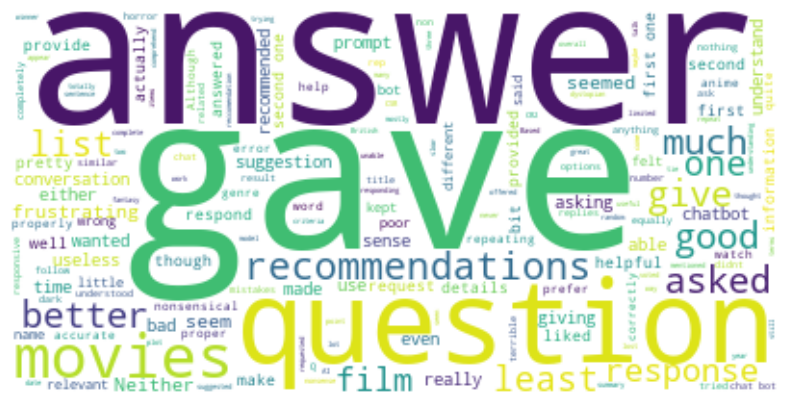

In [38]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(feedback_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Closed vs. open crowdsourcing

In [39]:
def calculate_stats(dialogues):
    turns = [len(conv['conversation']) for conv in dialogues]
    words = [len(turn['utterance'].split()) for conv in dialogues for turn in conv['conversation']]
    responses = [turn['utterance'] for conv in dialogues for turn in conv['conversation']]
    return np.mean(turns), np.mean(words), DistinctNgrams(n=2).calculate_normalized_distinct_n(responses)

open_stats = calculate_stats(dk_dialogues)
closed_stats = calculate_stats(dk_dialogues_prolific)

stats_df = pd.DataFrame({
    'Metric': ['#Utterances per dialogue', '#Words per turn', 'Diversity (Distinct-2)'],
    'Open crowdsourcing': [f"{open_stats[0]:.2f}", f"{open_stats[1]:.2f}", f"{open_stats[2]:.3f}"],
    'Closed crowdsourcing': [f"{closed_stats[0]:.2f}", f"{closed_stats[1]:.2f}", f"{closed_stats[2]:.3f}"]
})

print("Comparison between conversations collected in open and closed crowdsourcing environments:")
stats_df

Comparison between conversations collected in open and closed crowdsourcing environments:


,Metric,Open crowdsourcing,Closed crowdsourcing
0,#Utterances per dialogue,8.13,11.15
1,#Words per turn,11.01,11.59
2,Diversity (Distinct-2),0.527,0.538


## Correlation analysis

Correlation analysis between open and closed crowdsourcing environments.

In [40]:
crs_systems = list(elo_ratings['CRS'])

def get_elo_ratings(df, column, crs_list):
    """Retrieve values from a DataFrame for specified CRS systems."""
    return [df.loc[df['CRS'] == crs, column].values[0] if crs in df['CRS'].values else None for crs in crs_list]

def get_satisfaction(crowdsourcing_type):
    """Extract satisfaction percentages for CRS systems based on crowdsourcing type."""
    return [sentiment_distribution.loc[crs, (crowdsourcing_type, '% Satisfied')] if crs in sentiment_distribution.index else None for crs in crs_systems]

open_elo = get_elo_ratings(elo_ratings_open, 'Elo rating', crs_systems)
closed_elo = get_elo_ratings(elo_ratings_closed, 'Elo rating', crs_systems)

open_satisfaction = get_satisfaction('Open crowdsourcing')
closed_satisfaction = get_satisfaction('Closed crowdsourcing')

elo_pearson, elo_spearman = pearsonr(open_elo, closed_elo)[0], spearmanr(open_elo, closed_elo)[0]
satisfaction_pearson, satisfaction_spearman = pearsonr(open_satisfaction, closed_satisfaction)[0], spearmanr(open_satisfaction, closed_satisfaction)[0]

correlation_df = pd.DataFrame({
    'Metric': ['Elo ratings', 'Satisfaction'],
    "Pearson": [f"{elo_pearson:.3f}", f"{satisfaction_pearson:.3f}"],
    "Spearman": [f"{elo_spearman:.3f}", f"{satisfaction_spearman:.3f}"]
})

display(correlation_df)

,Metric,Pearson,Spearman
0,Elo ratings,0.763,0.700
1,Satisfaction,0.843,0.726


Correlation between Elo ratings and satisfaction for "closed & open" crowdsourcing environment.

In [41]:
combined_elo = get_elo_ratings(elo_ratings, 'Elo rating', crs_systems)
combined_satisfaction = get_satisfaction('Combined')
combined_spearman = spearmanr(combined_elo, combined_satisfaction)[0]

print(f"Elo ratings vs. satisfaction (Spearman): {combined_spearman:.3f}")

Elo ratings vs. satisfaction (Spearman): 0.917


Calculate Spearman correlation between R@10 and Elo ratings.

In [42]:
# R@10 values from the iEvaLM paper (Wang et al. 2023)
recall_data = {
    "barcor_opendialkg": 0.453,
    "barcor_redial": 0.170,
    "crbcrs_redial": None,
    "chatgpt_opendialkg": 0.539,
    "chatgpt_redial": 0.174,
    "kbrd_opendialkg": 0.423,
    "kbrd_redial": 0.169,
    "unicrs_opendialkg": 0.513,
    "unicrs_redial": 0.215
}

valid_recall = []
valid_elo = []
for crs in crs_systems:
    if crs in recall_data and recall_data[crs] is not None:
        valid_recall.append(recall_data[crs])
        valid_elo.append(elo_ratings.loc[elo_ratings['CRS'] == crs, 'Elo rating'].values[0])
        
# Calculate Spearman correlation between R@10 and Elo ratings
recall_elo_spearman = spearmanr(valid_recall, valid_elo)[0]

print(f"R@10 vs. Elo ratings (Spearman): {recall_elo_spearman:.3f}")

R@10 vs. Elo ratings (Spearman): -0.238
